## Telecom Churn Case Study

In [1]:
# Importing libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

## Reading data

In [2]:
init_db = pd.read_csv("telecom_churn_data.csv", encoding = "ISO-8859-1")
init_db.head(), init_db.shape

(   mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
 0     7000842753        109            0.00            0.00            0.00   
 1     7001865778        109            0.00            0.00            0.00   
 2     7001625959        109            0.00            0.00            0.00   
 3     7001204172        109            0.00            0.00            0.00   
 4     7000142493        109            0.00            0.00            0.00   
 
   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
 0            6/30/2014            7/31/2014            8/31/2014   
 1            6/30/2014            7/31/2014            8/31/2014   
 2            6/30/2014            7/31/2014            8/31/2014   
 3            6/30/2014            7/31/2014            8/31/2014   
 4            6/30/2014            7/31/2014            8/31/2014   
 
   last_date_of_month_9  arpu_6  ...  sachet_3g_9  fb_user_6  fb_user_7  \
 0            9/30/2014  19

## EDA

In [3]:
cols = init_db.columns
t_cols = [i for i in cols if "total_rech_amt_" in i]
# t_cols
# 'total_rech_amt_6', 'total_rech_amt_7' are the amounnts to be used
# derived column tot_rech_6_7 --> recharge amounts for months 6 and 7
init_db['tot_rech_6_7'] = init_db['total_rech_amt_6'] + init_db['total_rech_amt_7']
init_db[['tot_rech_6_7', 'total_rech_amt_6', 'total_rech_amt_7']].head()
high_val_db = init_db[init_db['tot_rech_6_7'] >= np.percentile(init_db['tot_rech_6_7'], 70.0)]
high_val_db.shape

(30011, 227)

In [4]:
print("Dropping date columns and columns that have just 1 or all unique values.\n")
drop_cols = []
cols = high_val_db.columns
drop_cols = [i for i in cols if "date" in i in cols]
for i in range(0, len(high_val_db.columns)):
        if high_val_db.iloc[:, i].value_counts().count() == 1 or high_val_db.iloc[:, i].value_counts().count() == high_val_db.shape[0]:
            drop_cols.append(cols[i])
print(drop_cols)
high_val_db = high_val_db.drop(drop_cols, axis = 1)
high_val_db.shape

Dropping date columns and columns that have just 1 or all unique values.

['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9', 'mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9']


(30011, 202)

In [5]:
# Drop features with null values more than 35%
null_lim = (int) (high_val_db.shape[0]*0.35)
print(null_lim)
drop_cols=[]
for i in high_val_db.columns:
    if high_val_db[i].isnull().sum() >= null_lim:
        drop_cols.append(i)
        
print(drop_cols)
high_val_db = high_val_db.drop(drop_cols, axis=1)

# No null rows present
high_val_db.isnull().apply(lambda x: all(x), axis=1).sum()

10503
['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'night_pck_user_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9']


0

In [6]:
# churned customer addition
cols = high_val_db.columns
t_cols = [i for i in cols if "_9" in i]
t_cols
high_val_db['churned'] = high_val_db[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].apply(lambda x: 1 if x.total_ic_mou_9+x.total_og_mou_9+x.vol_2g_mb_9+x.vol_3g_mb_9 == 0 else 0, axis=1)
print(high_val_db[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9', 'churned']].head(10))
# delete columns of month 9
high_val_db = high_val_db.drop(t_cols, axis=1)
high_val_db.shape

    total_ic_mou_9  total_og_mou_9  vol_2g_mb_9  vol_3g_mb_9  churned
7             0.00            0.00         0.00         0.00        1
8            34.91          142.18         0.00         0.00        0
13          631.86          446.09         0.00         0.00        0
16          334.56          255.74         0.00         0.00        0
17           87.13          631.08         0.00         0.00        0
21          252.61         1031.53         0.00         0.00        0
24          330.03          627.78         0.00         0.00        0
33          114.16            1.70        30.92      5588.11        0
38          114.09          708.04         0.00         0.00        0
41          165.84           89.13         0.00         0.00        0


(30011, 127)

In [7]:
# All columns are nummerical
for i in high_val_db.columns:
    if high_val_db[i].dtype not in ['float64', 'int64']:
        print(i)

# Uniformly renaming columns
cols = high_val_db.columns
for i in cols:
    if any(x in i for x in ['jun', 'jul', 'aug', 'sep']):
        print(i)

high_val_db.rename(columns={'aug_vbc_3g':'vbc_3g_8', 'jul_vbc_3g':'vbc_3g_7', 'jun_vbc_3g':'vbc_3g_6', 'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

aug_vbc_3g
jul_vbc_3g
jun_vbc_3g
sep_vbc_3g


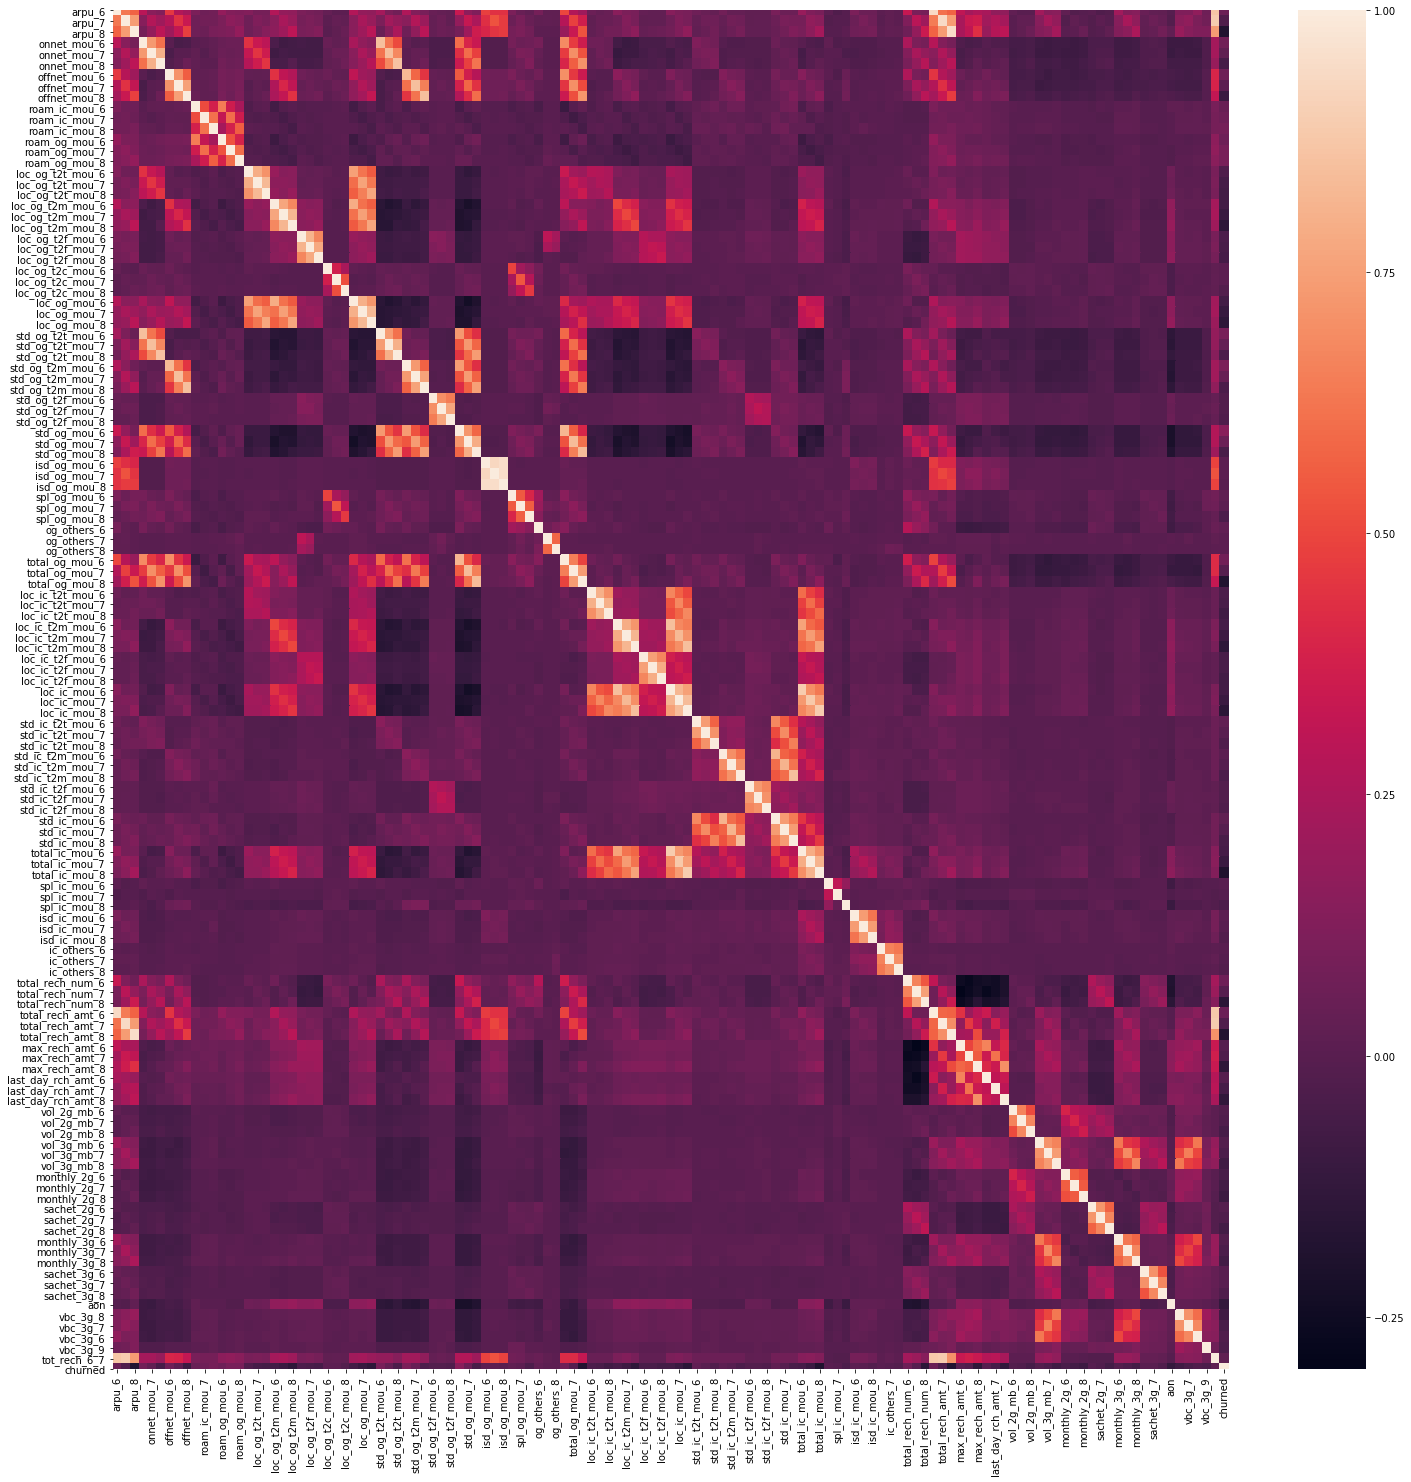

In [8]:
corr_mat = high_val_db.corr().round(2)
plt.figure(figsize=(25,25))
ax = sns.heatmap(corr_mat, annot=False)
plt.show()

(30011, 94)


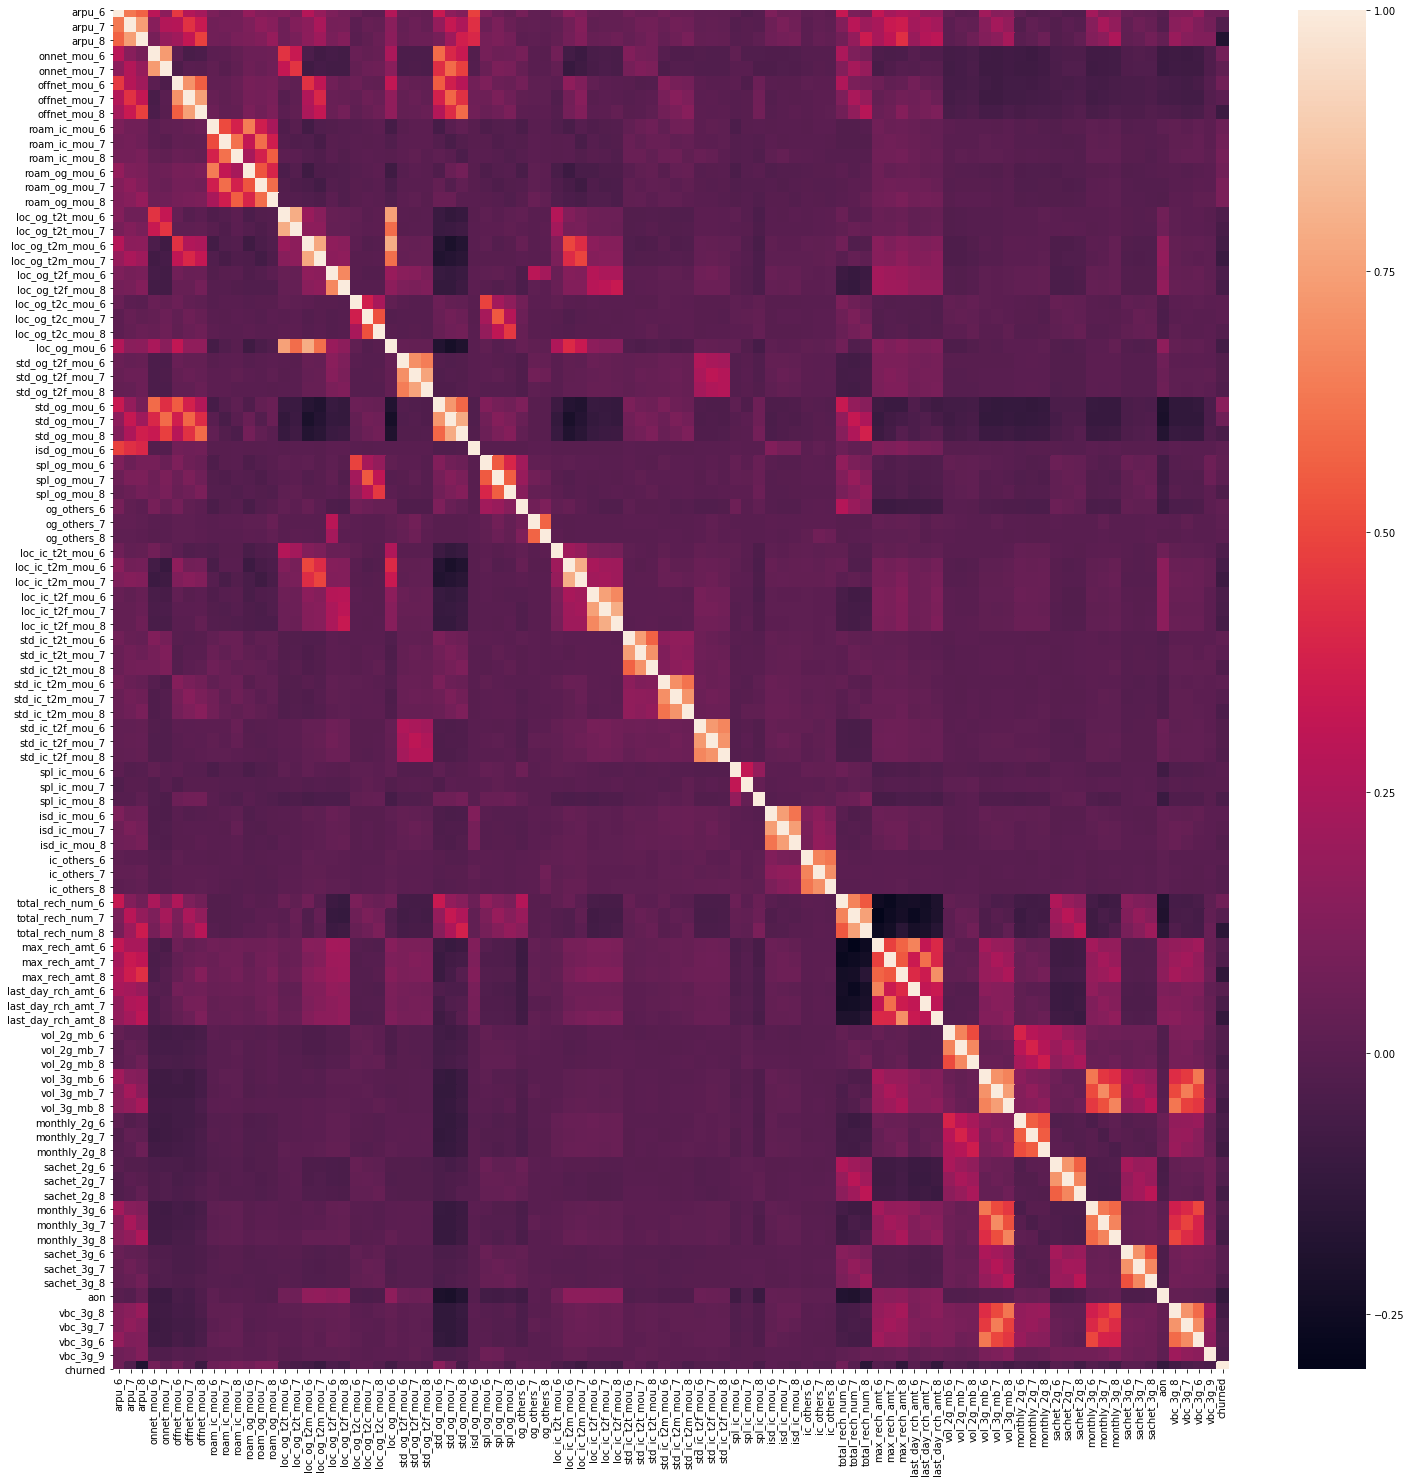

In [9]:
tril_mat = np.tril(corr_mat, -1)
st_mat = np.stack(tril_mat)
drop_ind = np.where(st_mat >= 0.80)[0]
high_val_db = high_val_db.drop(high_val_db.columns[drop_ind], axis = 1)
print(high_val_db.shape)
plt.figure(figsize=(25,25))
ax = sns.heatmap(high_val_db.corr(), annot=False)
plt.show()

In [10]:
null_val_counts = high_val_db[high_val_db.columns].isnull().sum().nlargest(60)
print(null_val_counts)
#high_val_db[null_val_counts.index][high_val_db['spl_ic_mou_7'].isnull()]
high_val_db[null_val_counts.index].median()

offnet_mou_8        938
roam_ic_mou_8       938
roam_og_mou_8       938
loc_og_t2f_mou_8    938
loc_og_t2c_mou_8    938
std_og_t2f_mou_8    938
std_og_mou_8        938
spl_og_mou_8        938
og_others_8         938
loc_ic_t2f_mou_8    938
std_ic_t2t_mou_8    938
std_ic_t2m_mou_8    938
std_ic_t2f_mou_8    938
spl_ic_mou_8        938
isd_ic_mou_8        938
ic_others_8         938
onnet_mou_6         316
offnet_mou_6        316
roam_ic_mou_6       316
roam_og_mou_6       316
loc_og_t2t_mou_6    316
loc_og_t2m_mou_6    316
loc_og_t2f_mou_6    316
loc_og_t2c_mou_6    316
loc_og_mou_6        316
std_og_t2f_mou_6    316
std_og_mou_6        316
isd_og_mou_6        316
spl_og_mou_6        316
og_others_6         316
loc_ic_t2t_mou_6    316
loc_ic_t2m_mou_6    316
loc_ic_t2f_mou_6    316
std_ic_t2t_mou_6    316
std_ic_t2m_mou_6    316
std_ic_t2f_mou_6    316
spl_ic_mou_6        316
isd_ic_mou_6        316
ic_others_6         316
onnet_mou_7         303
offnet_mou_7        303
roam_ic_mou_7   

offnet_mou_8       251.36
roam_ic_mou_8        0.00
roam_og_mou_8        0.00
loc_og_t2f_mou_8     0.31
loc_og_t2c_mou_8     0.00
std_og_t2f_mou_8     0.00
std_og_mou_8        84.73
spl_og_mou_8         0.68
og_others_8          0.00
loc_ic_t2f_mou_8     2.13
std_ic_t2t_mou_8     0.78
std_ic_t2m_mou_8     6.38
std_ic_t2f_mou_8     0.00
spl_ic_mou_8         0.00
isd_ic_mou_8         0.00
ic_others_8          0.00
onnet_mou_6        128.33
offnet_mou_6       285.96
roam_ic_mou_6        0.00
roam_og_mou_6        0.00
loc_og_t2t_mou_6    33.33
loc_og_t2m_mou_6   103.51
loc_og_t2f_mou_6     0.38
loc_og_t2c_mou_6     0.00
loc_og_mou_6       169.53
std_og_t2f_mou_6     0.00
std_og_mou_6       131.06
isd_og_mou_6         0.00
spl_og_mou_6         0.26
og_others_6          0.00
loc_ic_t2t_mou_6    29.64
loc_ic_t2m_mou_6    95.48
loc_ic_t2f_mou_6     2.06
std_ic_t2t_mou_6     1.13
std_ic_t2m_mou_6     7.33
std_ic_t2f_mou_6     0.00
spl_ic_mou_6         0.00
isd_ic_mou_6         0.00
ic_others_6 

In [11]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df = high_val_db
df[:] = imputer.fit_transform(high_val_db)

In [12]:
# The median values are comparable after null value imputation
print(high_val_db[null_val_counts.index].median())
high_val_db[high_val_db.columns].isnull().sum().nlargest()

offnet_mou_8       243.18
roam_ic_mou_8        0.00
roam_og_mou_8        0.00
loc_og_t2f_mou_8     0.32
loc_og_t2c_mou_8     0.00
std_og_t2f_mou_8     0.00
std_og_mou_8        80.49
spl_og_mou_8         0.75
og_others_8          0.00
loc_ic_t2f_mou_8     2.11
std_ic_t2t_mou_8     0.81
std_ic_t2m_mou_8     6.31
std_ic_t2f_mou_8     0.00
spl_ic_mou_8         0.00
isd_ic_mou_8         0.00
ic_others_8          0.00
onnet_mou_6        126.94
offnet_mou_6       283.58
roam_ic_mou_6        0.00
roam_og_mou_6        0.00
loc_og_t2t_mou_6    33.11
loc_og_t2m_mou_6   102.51
loc_og_t2f_mou_6     0.40
loc_og_t2c_mou_6     0.00
loc_og_mou_6       168.03
std_og_t2f_mou_6     0.00
std_og_mou_6       129.56
isd_og_mou_6         0.00
spl_og_mou_6         0.30
og_others_6          0.00
loc_ic_t2t_mou_6    29.59
loc_ic_t2m_mou_6    94.99
loc_ic_t2f_mou_6     2.09
std_ic_t2t_mou_6     1.16
std_ic_t2m_mou_6     7.39
std_ic_t2f_mou_6     0.00
spl_ic_mou_6         0.00
isd_ic_mou_6         0.00
ic_others_6 

arpu_6         0
arpu_7         0
arpu_8         0
onnet_mou_6    0
onnet_mou_7    0
dtype: int64

count   30011.00
mean       41.65
std        32.49
min         6.00
25%        16.00
50%        30.00
75%        64.00
max       144.00
Name: aon_m, dtype: float64


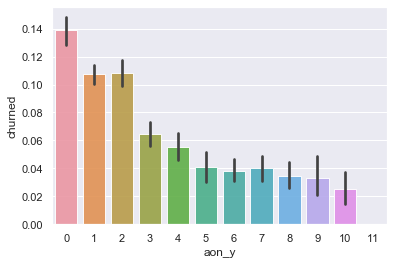

1    0.25
0    0.16
2    0.16
3    0.10
6    0.07
4    0.07
7    0.06
8    0.05
5    0.04
9    0.02
10   0.02
11   0.00
Name: aon_y, dtype: float64

In [13]:
# Converting aon from days to weeks, months and years
# high_val_db['aon_w'] = (high_val_db['aon']/7).astype('int64')
high_val_db['aon_m'] = (high_val_db['aon']/30).astype('int64')
high_val_db.groupby(['churned'])['aon_m'].value_counts()
print(high_val_db.aon_m.describe())
high_val_db['aon_y'] = (high_val_db['aon']/365).astype('int64')
sns.set(style="darkgrid")
ax = sns.barplot('aon_y', 'churned', alpha=0.9, data=high_val_db)
#ax.title.set_text(grades[r][c].upper()+' Grade Vs Loan Status')
plt.show()
high_val_db['aon_y'].value_counts(normalize=True)

Most users have 0 to 3 years of usage and the churn percentage decreases as period of use increases

In [14]:
## The tenure will be standardised before classification. Hence, dropping the added columns
high_val_db = high_val_db.drop(['aon_m', 'aon_y'], axis=1)

<Figure size 1800x1800 with 0 Axes>

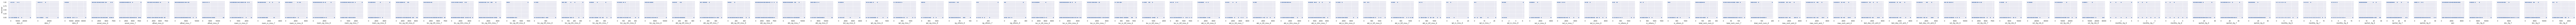

In [15]:
X=high_val_db.drop(['churned'], axis=1)
plt.figure(figsize=(25,25))
sns.pairplot(high_val_db, x_vars=X.columns, y_vars='churned')
plt.show()

## Modeling

In [98]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

In [99]:
X = high_val_db.drop(['churned'], axis=1)
y = high_val_db['churned']

In [100]:
X.shape, y.shape, high_val_db.shape

((30011, 93), (30011,), (30011, 94))

In [101]:
# Sacle data and split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=42)
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

In [102]:
# Churned percentage in test and train data
print("Test Data: ", (y_test==1).sum()/len(y_test))
print("Train Data: ", (y_train==1).sum()/len(y_train))

Test Data:  0.0858507330075522
Train Data:  0.0866377874041986


In [103]:
#sm = SMOTE()
#X_trains, y_trains = (X_train,y_train)
print(X_train.shape)
print(y_train.shape)

(21007, 93)
(21007,)


## Logistic Regression

In [104]:
# Logistic Regression with RFE
# using balanced class_weights
lr = LogisticRegression(random_state=42, class_weight='balanced')
rfe = RFE(lr, 35)   
rfe = rfe.fit(X_train, y_train)

In [105]:
# Top features
col = X_train.columns[rfe.support_]
print(list(X_train.columns[rfe.support_]))

['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_7', 'offnet_mou_7', 'offnet_mou_8', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_7', 'loc_og_t2f_mou_8', 'std_og_mou_7', 'isd_og_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2f_mou_8', 'spl_ic_mou_7', 'spl_ic_mou_8', 'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'max_rech_amt_6', 'max_rech_amt_7', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_7', 'sachet_3g_8', 'aon', 'vbc_3g_9']


In [106]:
X_train_rfe = X_train[col]
y_train_rfe = y_train
lr = LogisticRegression(random_state=42, class_weight='balanced')
lr.fit(X_train_rfe, y_train_rfe)

X_test_rfe = X_test[col]

y_pred = lr.predict(X_test_rfe)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[6665 1566]
 [ 145  628]]


In [107]:
# Actual/Predicted     not_churn    churn
        # not_churn        6665      1566
        # churn            145       628

In [108]:
print('Accuracy of Logistic Regression: ', (lr.score(X_test_rfe, y_test)*100).round(2), "%.")

Accuracy of Logistic Regression:  81.0 %.


In [109]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [110]:
sensitivity = TP / float(TP+FN)
print("Sensitivity: ", sensitivity)
specificity = TN / float(TN+FP)
print("Specificity: ", specificity)
false_pos_rate = FP/ float(TN+FP)
print("False positive rate: ", false_pos_rate)
pos_pred_value = TP / float(TP+FP)
print("Positive predictive value: ", pos_pred_value)
neg_pred_value = TN / float(TN+FN)
print("Negative predictive value: ", neg_pred_value)

Sensitivity:  0.8124191461836999
Specificity:  0.8097436520471388
False positive rate:  0.19025634795286114
Positive predictive value:  0.2862351868732908
Negative predictive value:  0.9787077826725403


In [111]:
y_train_pred_final = pd.DataFrame({'churn_actual':y_test, 'churn_pred':y_pred})
y_train_pred_final.head(5)

,churn_actual,churn_pred
39713,0.00,0.00
80955,1.00,1.00
80034,0.00,1.00
93911,0.00,0.00
55461,0.00,0.00


**Analysis**<br>
-> Using Logistic Regression with RFE, the accuracy is 81% and Predictive Power of Churned customers is 28.6%.<br>
-> High accuracy of 97.8% is obtained in predcting customers that don't churn.

## PCA

In [30]:
#Using SMOTE for imbalanced data
sm = SMOTE()
X_trains, y_trains = sm.fit_sample(X_train,y_train)
print(X_trains.shape)
print(y_trains.shape)

(38374, 93)
(38374,)


In [31]:
print("Test Data: ", (y_test==1).sum()/len(y_test))
print("Train Data: ", (y_trains==1).sum()/len(y_trains))

Test Data:  0.0858507330075522
Train Data:  0.5


In [32]:
pca = PCA(random_state = 42)
pca.fit(X_trains)
X_train_pca = pca.fit_transform(X_trains)

X_test_pca = pca.transform(X_test)

## Logistic Regression with PCA

In [33]:
lr_pca = LogisticRegression()
lr_pca.fit(X_train_pca, y_trains)

# Predicted probabilities
y_pred = lr_pca.predict(X_test_pca)

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))

[[6784 1447]
 [ 158  615]]


In [35]:
print("Accuracy of Logistic Regression with PCA_93: ", (accuracy_score(y_test,y_pred)*100).round(2), "%.")

Accuracy of Logistic Regression with PCA_93:  82.17 %.


In [36]:
col = list(X_trains.columns)
print(pca.components_.shape)
db_pca = pd.DataFrame({'C1':pca.components_[0],'C2':pca.components_[1], 'C3':pca.components_[2], 'C4':pca.components_[3], 'Features':col})
db_pca.head()

(93, 93)


,C1,C2,C3,C4,Features
0,0.13,0.13,0.19,-0.05,arpu_6
1,0.16,0.12,0.24,-0.10,arpu_7
2,0.20,0.08,0.19,-0.09,arpu_8
3,-0.10,0.14,0.13,-0.02,onnet_mou_6
4,-0.07,0.14,0.15,-0.05,onnet_mou_7


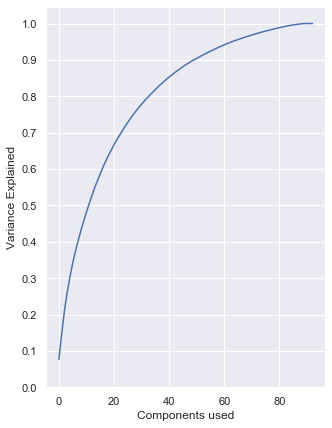

In [37]:
fig = plt.figure(figsize = (5, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components used')
plt.ylabel('Variance Explained')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [ ]:
# 90% variance is explained by around 50 components
pca_48 = PCA(n_components = 48)

df_train_pca_48 = pca_48.fit_transform(X_trains)
print(df_train_pca_48.shape)

df_test_pca_48 = pca_48.transform(X_test)
print(df_test_pca_48.shape)

In [ ]:
lr_pca1 = LogisticRegression(random_state = 42)
lr_pca1.fit(df_train_pca_48, y_trains)

# Predicted probabilities
y_pred_48 = lr_pca1.predict(df_test_pca_48)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred_48)
print(confusion_matrix(y_test,y_pred_48))

In [ ]:
confusion = confusion_matrix(y_test, rf_y_pred)
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
sensitivity = TP / float(TP+FN)
print("Sensitivity: ", sensitivity)
specificity = TN / float(TN+FP)
print("Specificity: ", specificity)
false_pos_rate = FP/ float(TN+FP)
print("False positive rate: ", false_pos_rate)
pos_pred_value = TP / float(TP+FP)
print("Positive predictive value: ", pos_pred_value)
neg_pred_value = TN / float(TN+FN)
print("Negative predictive value: ", neg_pred_value)
print ('Accuracy of Random Forest with Hyperparameter tuning:', (metrics.accuracy_score(y_test, y_pred_48)*100).round(2), "%.")

**Analysis**<br>
-> Accuracy of 81.96% is obtained with Logistic Regression with PCA_48.<br>
-> Sensitivity is lower than without PCA.<br>
-> The time taken to fit the model and predict is very less compared to other models.

## Random Forests

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [ ]:
# Use Lasso Regression to reduce features
lsvc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_trains, y_trains)
model = SelectFromModel(lsvc, prefit=True)
X_lasso = model.transform(X_trains)
ind = model.get_support(indices=True)
print(X_lasso.shape)
print(ind)

In [43]:
rf_vanilla = RandomForestClassifier()
rf_vanilla.fit(X_lasso, y_trains)

# Make predictions
X_test_rf = pd.DataFrame(data = X_test).iloc[:, ind]
rf_y_test = rf_vanilla.predict(X_test_rf)
print(rf_vanilla)
print ('Accuracy of Randon Forest without Hyperparameter tuning: ',(metrics.accuracy_score(y_test, rf_y_test)*100).round(2), "%.")

Accuracy of Randon Forest without Hyperparameter tuning:  92.5 %.


In [44]:
confusion = confusion_matrix(y_test, prediction_test)
print(confusion)

[[7811  420]
 [ 255  518]]


In [45]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
sensitivity = TP / float(TP+FN)
print("Sensitivity: ", sensitivity)
specificity = TN / float(TN+FP)
print("Specificity: ", specificity)
false_pos_rate = FP/ float(TN+FP)
print("False positive rate: ", false_pos_rate)
pos_pred_value = TP / float(TP+FP)
print("Positive predictive value: ", pos_pred_value)
neg_pred_value = TN / float(TN+FN)
print("Negative predictive value: ", neg_pred_value)

Sensitivity:  0.6701164294954722
Specificity:  0.9489733932693476
False positive rate:  0.05102660673065241
Positive predictive value:  0.5522388059701493
Negative predictive value:  0.9683858170096702


*Find min_samples_split*

In [ ]:
k_fold = 5
param = {'min_samples_split': range(50, 500, 50)}
rf_mss = RandomForestClassifier()
rf_mss = GridSearchCV(rf_mss, param, cv=k_fold, scoring="accuracy")
rf_mss.fit(X_lasso, y_trains)

In [ ]:
scores_mss = rf_mss.cv_results_
pd.DataFrame(scores_mss).head()

In [ ]:
plt.figure()
plt.plot(scores_mss["param_min_samples_split"], scores_mss["mean_test_score"], label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

*Find min_samples_leaf*

In [ ]:
k_fold = 5
param = {'min_samples_leaf': range(50, 300, 20)}
rf_msl = RandomForestClassifier()
rf_msl = GridSearchCV(rf_msl, param, cv=k_fold, scoring="accuracy")
rf_msl.fit(X_lasso, y_trains)

In [ ]:
scores_msl = rf_msl.cv_results_
plt.figure()
plt.plot(scores_msl["param_min_samples_leaf"], scores_msl["mean_test_score"], label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

*Find max_depth*

In [ ]:
k_fold = 5
param = {'max_depth': range(2, 20, 3)}
rf_md = RandomForestClassifier()
rf_md = GridSearchCV(rf_md, param, cv=k_fold, scoring="accuracy")
rf_md.fit(X_lasso, y_trains)

In [ ]:
scores_md = rf_md.cv_results_
plt.figure()
plt.plot(scores_md["param_max_depth"], scores_md["mean_test_score"], label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [113]:
rf_hyp_param = RandomForestClassifier(min_samples_split=75, min_samples_leaf=50, max_depth=15, 
                                  oob_score = True, random_state =42, bootstrap=True)
rf_hyp_param.fit(X_trains, y_trains)
# Prediction on the test data
rf_y_pred = rf_hyp_param.predict(X_test)

In [114]:
confusion = confusion_matrix(y_test, rf_y_pred)
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
sensitivity = TP / float(TP+FN)
print("Sensitivity: ", sensitivity)
specificity = TN / float(TN+FP)
print("Specificity: ", specificity)
false_pos_rate = FP/ float(TN+FP)
print("False positive rate: ", false_pos_rate)
pos_pred_value = TP / float(TP+FP)
print("Positive predictive value: ", pos_pred_value)
neg_pred_value = TN / float(TN+FN)
print("Negative predictive value: ", neg_pred_value)
print ('Accuracy of Random Forest with Hyperparameter tuning:', (metrics.accuracy_score(y_test, rf_y_pred)*100).round(2), "%.")

[[7529  702]
 [ 191  582]]
Sensitivity:  0.7529107373868047
Specificity:  0.9147126716073382
False positive rate:  0.08528732839266188
Positive predictive value:  0.4532710280373832
Negative predictive value:  0.975259067357513
Accuracy of Random Forest with Hyperparameter tuning: 90.08 %.


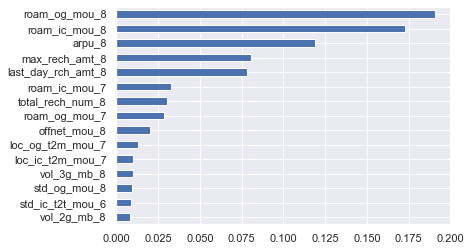

In [115]:
# Plotting important features
features = X.columns.values
X = pd.DataFrame(scaler.transform(X))
X.columns = features

importances = rf_hyp_param.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
abs(weights).sort_values()[-15:].plot(kind = 'barh')

**Analysis**<br>
-> The accuracy with Random Forests is between 90 and 92% and Positive predictive power of 45%.<br>
-> The beahvior in the 8th month is very essential in indentifying churn with top predictors being:<br>
total_rech_num_8, last_day_rch_amt_8, max_rech_amt_8, arpu_8, roam_ic_mou_8, roam_og_mou_8 

## Decision Trees

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [59]:
dt_vanilla = DecisionTreeClassifier(max_depth=5)
dt_vanilla.fit(X_lasso, y_trains)

DecisionTreeClassifier(max_depth=5)

In [60]:
X_test_dt = pd.DataFrame(data=X_test).iloc[:, ind]
y_pred_vanilla = dt_vanilla.predict(X_test_dt)
print('Accuracy of Decision Tree without hyperparameter tuning :', (accuracy_score(y_test,y_pred1)*100).round(2), "%.")

In [61]:
confusion = confusion_matrix(y_test, prediction_test)
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
sensitivity = TP / float(TP+FN)
print("Sensitivity: ", sensitivity)
specificity = TN / float(TN+FP)
print("Specificity: ", specificity)
false_pos_rate = FP/ float(TN+FP)
print("False positive rate: ", false_pos_rate)
pos_pred_value = TP / float(TP+FP)
print("Positive predictive value: ", pos_pred_value)
neg_pred_value = TN / float(TN+FN)
print("Negative predictive value: ", neg_pred_value)

[[7336  895]
 [ 180  593]]
Sensitivity:  0.7671410090556274
Specificity:  0.8912647308953955
False positive rate:  0.10873526910460454
Positive predictive value:  0.39852150537634407
Negative predictive value:  0.9760510910058542


*max_depth tuning*

In [62]:
k_fold = 5
param = {'max_depth': range(1, 40, 2)}
dt_md = DecisionTreeClassifier(criterion = "gini", random_state = 42)
dt_md = GridSearchCV(dt_md, param, cv=k_fold, scoring="accuracy")
dt_md.fit(X_lasso, y_trains)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': range(1, 40)}, scoring='accuracy')

In [63]:
score_md = dt_md.cv_results_
pd.DataFrame(score_md).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.23,0.01,0.01,0.00,1,{'max_depth': 1},0.80,0.84,0.84,0.84,0.84,0.83,0.02,39
1,0.40,0.04,0.00,0.00,2,{'max_depth': 2},0.84,0.87,0.87,0.87,0.87,0.86,0.01,38
2,0.49,0.02,0.00,0.00,3,{'max_depth': 3},0.82,0.88,0.88,0.88,0.88,0.87,0.02,37
3,0.62,0.02,0.00,0.00,4,{'max_depth': 4},0.84,0.89,0.89,0.89,0.89,0.88,0.02,36
4,0.78,0.04,0.00,0.00,5,{'max_depth': 5},0.84,0.90,0.90,0.89,0.90,0.89,0.02,35


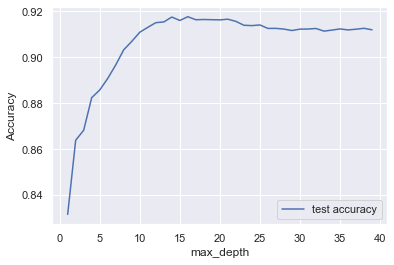

In [64]:
plt.figure()
plt.plot(score_md["param_max_depth"], score_md["mean_test_score"], label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

*min_sample_leaf tuning*

In [73]:
k_fold = 5
param = {'min_samples_leaf': range(10, 300, 20)}
dt_msl = DecisionTreeClassifier(criterion = "gini", random_state = 42)
dt_msl = GridSearchCV(dt_msl, param, cv=k_fold, scoring="accuracy")
dt_msl.fit(X_lasso, y_trains)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'min_samples_leaf': range(10, 300, 20)},
             scoring='accuracy')

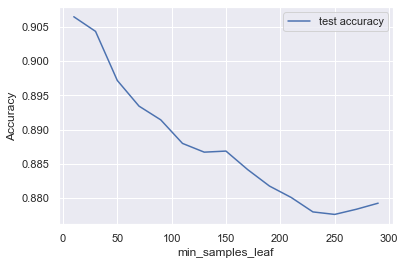

In [75]:
score_msl = dt_msl.cv_results_
plt.figure()
plt.plot(score_msl["param_min_samples_leaf"], score_msl["mean_test_score"], label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

*min_sample_split tuning*

In [77]:
k_fold = 5
param = {'min_samples_split': range(50, 500, 50)}
dt_mss = DecisionTreeClassifier(criterion = "gini", random_state = 42)
dt_mss = GridSearchCV(dt_mss, param, cv=k_fold, scoring="accuracy")
dt_mss.fit(X_lasso, y_trains)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'min_samples_split': range(50, 500, 50)},
             scoring='accuracy')

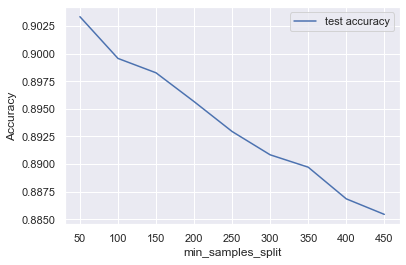

In [80]:
score_mss = dt_mss.cv_results_
plt.figure()
plt.plot(score_mss["param_min_samples_split"], score_mss["mean_test_score"], label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

*Tuning all parameters together*

In [82]:
params = {'min_samples_split': range(50, 500, 50), 'min_samples_leaf': range(10, 300, 20),'max_depth': range(1, 40, 2),'criterion': ["entropy", "gini"]}
k_fold = 5
dt_hyp = DecisionTreeClassifier()
dt_hyp = GridSearchCV(estimator=dt_hyp, param_grid=params, cv=k_fold, verbose=1, n_jobs=3)
dt_hyp.fit(X_lasso, y_trains)

Fitting 5 folds for each of 5400 candidates, totalling 27000 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    9.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   25.7s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   53.4s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:  3.9min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:  7.7min
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed: 13.3min
[Parallel(n_jobs=3)]: Done 3194 tasks      | elapsed: 20.4min
[Parallel(n_jobs=3)]: Done 4044 tasks      | elapsed: 29.2min
[Parallel(n_jobs=3)]: Done 4994 tasks      | elapsed: 40.4min
[Parallel(n_jobs=3)]: Done 6044 tasks      | elapsed: 52.8min
[Parallel(n_jobs=3)]: Done 7194 tasks      | elapsed: 67.4min
[Parallel(n_jobs=3)]: Done 8444 tasks      | elapsed: 83.7min
[Parallel(n_jobs=3)]: Done 9794 tasks      | elapsed: 101.4min
[Parallel(n_jobs=3)]: Done 11244 tasks      | elapsed: 118.8

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=3,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 40, 2),
                         'min_samples_leaf': range(10, 300, 20),
                         'min_samples_split': range(50, 500, 50)},
             verbose=1)

In [94]:
gcv_result = pd.DataFrame(dt_hyp.cv_results_)
gcv_result
# Output of best accuracy score and hyperparameters
print("Best Accuracy: ", dt_hyp.best_score_)
print("Hyperparameters: ", dt_hyp.best_estimator_)

Best Accuracy:  0.9115028315926107
Hyperparameters:  DecisionTreeClassifier(criterion='entropy', max_depth=29, min_samples_leaf=10,
                       min_samples_split=50)


In [95]:
dt_ent = DecisionTreeClassifier(random_state = 42, criterion = "entropy", min_samples_split=50, min_samples_leaf=10, max_depth=17)
dt_ent.fit(X_lasso, y_trains)

DecisionTreeClassifier(criterion='entropy', max_depth=17, min_samples_leaf=10,
                       min_samples_split=50, random_state=42)

In [96]:
print ('Accuracy of Decision Tree model after Hyperparameter tuning:', (dt_ent.score(X_test,y_test)*100).round(2), "%.")

Accuracy of Decision Tree model after Hyperparameter tuning: 88.88 %.


The model has been fitted with max_depth of 17 instead of 29 as it might lead to overfitting.

## Conclusion

- Most customers have been using the network since 3 years or less
- Churn is also maimum for users in this period
- The usage and recharge details of the 8th month are crucial in determining churn
- The accuracy of random forests is the highest (90-92%), followed by decision trees (86 - 88%) and then by logistic regression (79-82%)
- The most important features in determining churn are: total_rech_num_8, last_day_rch_amt_8, max_rech_amt_8, arpu_8, roam_ic_mou_8, roam_og_mou_8
